In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn tensorflow


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report,roc_curve
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score

In [2]:
df = pd.read_csv("kddcup.data_10_percent_corrected", header=None)

In [3]:
df

0    1     2   3    4     5   6   7   8   9   ...   32   33   34  \
0        0  tcp  http  SF  181  5450   0   0   0   0  ...    9  1.0  0.0   
1        0  tcp  http  SF  239   486   0   0   0   0  ...   19  1.0  0.0   
2        0  tcp  http  SF  235  1337   0   0   0   0  ...   29  1.0  0.0   
3        0  tcp  http  SF  219  1337   0   0   0   0  ...   39  1.0  0.0   
4        0  tcp  http  SF  217  2032   0   0   0   0  ...   49  1.0  0.0   
...     ..  ...   ...  ..  ...   ...  ..  ..  ..  ..  ...  ...  ...  ...   
494016   0  tcp  http  SF  310  1881   0   0   0   0  ...  255  1.0  0.0   
494017   0  tcp  http  SF  282  2286   0   0   0   0  ...  255  1.0  0.0   
494018   0  tcp  http  SF  203  1200   0   0   0   0  ...  255  1.0  0.0   
494019   0  tcp  http  SF  291  1200   0   0   0   0  ...  255  1.0  0.0   
494020   0  tcp  http  SF  219  1234   0   0   0   0  ...  255  1.0  0.0   

          35    36    37    38   39   40       41  
0       0.11  0.00  0.00  0.00  0.0  0.0  normal.  
1       0.05  0.00  0.00  0.00  0.0  0.0  normal.  
2       0.03  0.00  0.00  0.00  0.0  0.0  normal.  
3       0.03  0.00  0.00  0.00  0.0  0.0  normal.  
4       0.02  0.00  0.00  0.00  0.0  0.0  normal.  
...      ...   ...   ...   ...  ...  ...      ...  
494016  0.01  0.05  0.00  0.01  0.0  0.0  normal.  
494017  0.17  0.05  0.00  0.01  0.0  0.0  normal.  
494018  0.06  0.05  0.06  0.01  0.0  0.0  normal.  
494019  0.04  0.05  0.04  0.01  0.0  0.0  normal.  
494020  0.17  0.05  0.00  0.01  0.0  0.0  normal.  

[494021 rows x 42 columns]

In [4]:
columns = [f"feature_{i}" for i in range(df.shape[1]-1)] + ["label"]
df.columns = columns

In [5]:
cat_cols = ['feature_1', 'feature_2', 'feature_3']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [6]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

In [7]:
X = df.drop(columns=["label"])
y = df["label"]
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [8]:
# Isolation Forest 
iso = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso.fit(X_train[y_train == 0])
iso_scores = -iso.decision_function(X_test)
iso_thresh = np.percentile(iso_scores[y_test == 0], 90)
y_pred_iso = (iso_scores > iso_thresh).astype(int)

In [9]:
# Autoencoder 
input_dim = X_train.shape[1]
inp = Input(shape=(input_dim,))
enc = Dense(32, activation='relu')(inp)
enc = Dense(16, activation='relu')(enc)
dec = Dense(32, activation='relu')(enc)
out = Dense(input_dim, activation='sigmoid')(dec)
ae = Model(inp, out)
ae.compile(optimizer=Adam(0.001), loss='mse')

ae.fit(X_train[y_train == 0], X_train[y_train == 0], epochs=20, batch_size=256, validation_split=0.1, verbose=0)
recon = ae.predict(X_test)
recon_error = np.mean(np.square(X_test - recon), axis=1)
ae_thresh = np.percentile(recon_error[y_test == 0], 90)
y_pred_ae = (recon_error > ae_thresh).astype(int)



4632/4632 [==============================] - 3s 683us/step


In [10]:
print(f"Anomalies by Isolation Forest: {sum(y_pred_iso)} ({sum(y_pred_iso)/len(y_pred_iso)*100:.2f}%)")
print(f"Anomalies by Autoencoder: {sum(y_pred_ae)} ({sum(y_pred_ae)/len(y_pred_ae)*100:.2f}%)")


Anomalies by Isolation Forest: 120934 (81.60%)
Anomalies by Autoencoder: 10080 (6.80%)


In [11]:
#Evaluation 
acc_if = accuracy_score(y_test, y_pred_iso)
acc_ae = accuracy_score(y_test, y_pred_ae)
auc_if = roc_auc_score(y_test, iso_scores)
auc_ae = roc_auc_score(y_test, recon_error)

print(f"\nIsolation Forest - Accuracy: {acc_if:.3f}, AUC: {auc_if:.3f}")
print(f"Autoencoder      - Accuracy: {acc_ae:.3f}, AUC: {auc_ae:.3f}")

print("\nClassification Report - Isolation Forest:\n", classification_report(y_test, y_pred_iso))
print("\nClassification Report - Autoencoder:\n", classification_report(y_test, y_pred_ae))



Isolation Forest - Accuracy: 0.974, AUC: 0.980
Autoencoder      - Accuracy: 0.226, AUC: 0.259

Classification Report - Isolation Forest:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     29192
           1       0.98      0.99      0.98    119015

    accuracy                           0.97    148207
   macro avg       0.97      0.95      0.96    148207
weighted avg       0.97      0.97      0.97    148207


Classification Report - Autoencoder:
               precision    recall  f1-score   support

           0       0.19      0.90      0.31     29192
           1       0.71      0.06      0.11    119015

    accuracy                           0.23    148207
   macro avg       0.45      0.48      0.21    148207
weighted avg       0.61      0.23      0.15    148207



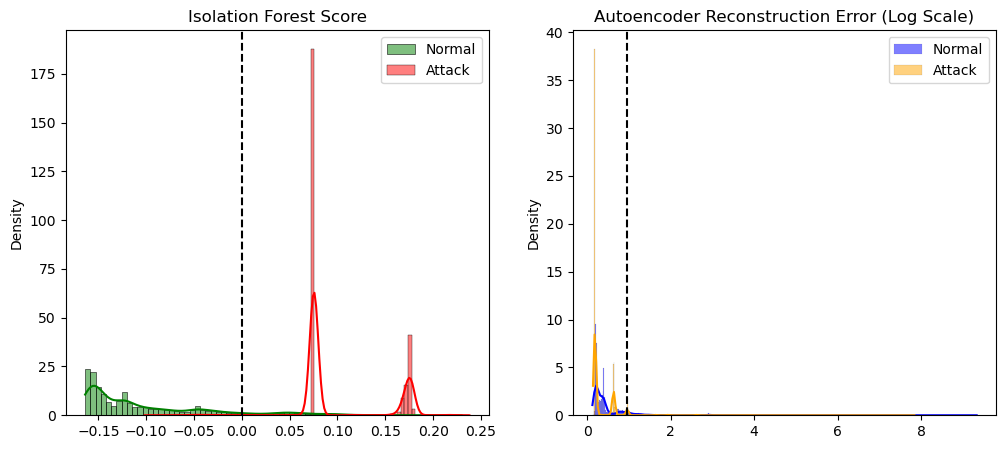

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(iso_scores[y_test==0], color='green', label='Normal', kde=True, stat="density")
sns.histplot(iso_scores[y_test==1], color='red', label='Attack', kde=True, stat="density")
plt.axvline(iso_thresh, color='black', linestyle='--')
plt.title("Isolation Forest Score")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(recon_error[y_test==0]), color='blue', label='Normal', kde=True, stat="density")
sns.histplot(np.log1p(recon_error[y_test==1]), color='orange', label='Attack', kde=True, stat="density")
plt.axvline(np.log1p(ae_thresh), color='black', linestyle='--')
plt.title("Autoencoder Reconstruction Error (Log Scale)")
plt.legend()


In [13]:
acc_if = accuracy_score(y_test, y_pred_iso)
acc_ae = accuracy_score(y_test, y_pred_ae)
auc_if = roc_auc_score(y_test, iso_scores)
auc_ae = roc_auc_score(y_test, recon_error)

print(f"Isolation Forest - Accuracy: {acc_if:.3f}, AUC: {auc_if:.3f}")
print(f"Autoencoder      - Accuracy: {acc_ae:.3f}, AUC: {auc_ae:.3f}")

Isolation Forest - Accuracy: 0.974, AUC: 0.980
Autoencoder      - Accuracy: 0.226, AUC: 0.259


Isolation Forest - F1 Score: 0.984
Autoencoder      - F1 Score: 0.111


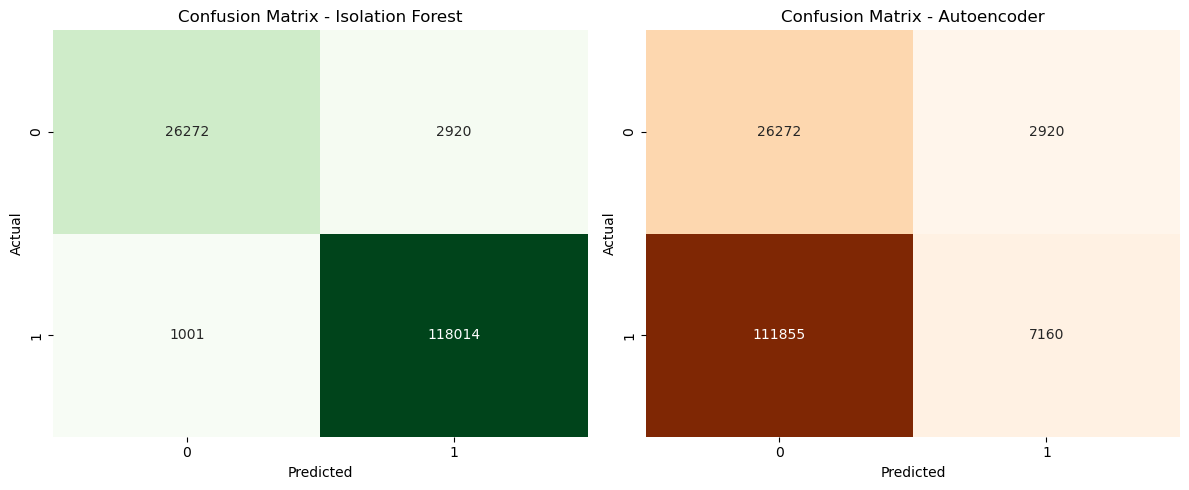

In [14]:
f1_if = f1_score(y_test, y_pred_iso)
f1_ae = f1_score(y_test, y_pred_ae)

print(f"Isolation Forest - F1 Score: {f1_if:.3f}")
print(f"Autoencoder      - F1 Score: {f1_ae:.3f}")

cm_if = confusion_matrix(y_test, y_pred_iso)
cm_ae = confusion_matrix(y_test, y_pred_ae)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_if, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix - Isolation Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")


plt.subplot(1, 2, 2)
sns.heatmap(cm_ae, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.title("Confusion Matrix - Autoencoder")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

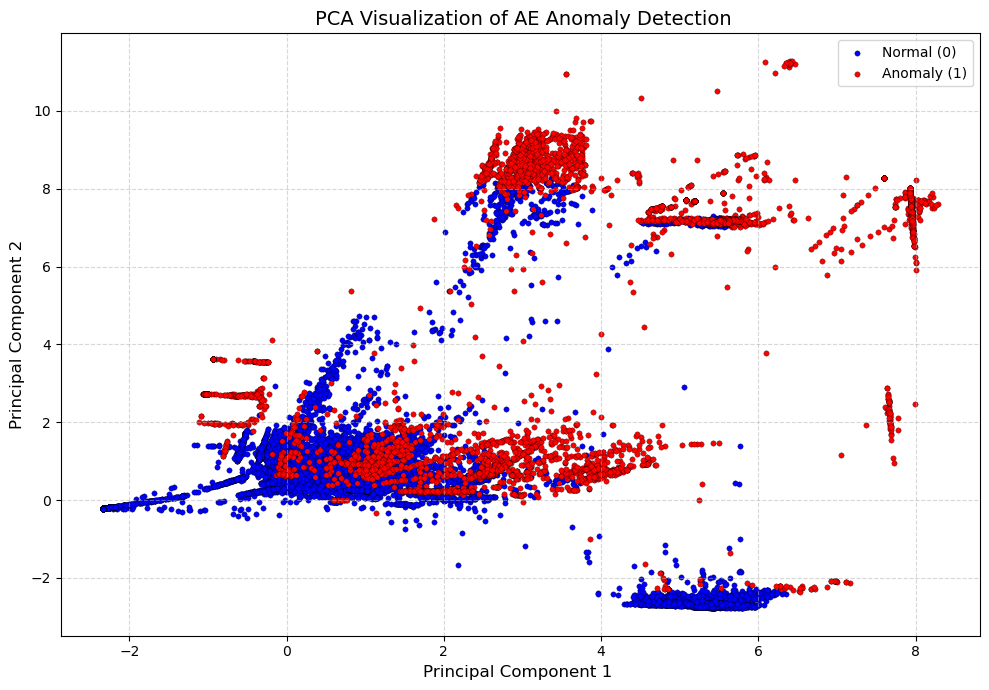

In [15]:
pca_results = PCA(n_components=2).fit_transform(X_test)

plt.figure(figsize=(10, 7))
for label, color, name in zip([0, 1], ['blue', 'red'], ['Normal (0)', 'Anomaly (1)']):
    idx = y_pred_ae == label
    plt.scatter(
        pca_results[idx, 0], pca_results[idx, 1],
        c=color, label=name,
        alpha=1.0,            
        s=15,
        edgecolors='k',
        linewidths=0.2
    )

plt.xlabel('Principal Component 1 ', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title(' PCA Visualization of AE Anomaly Detection', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


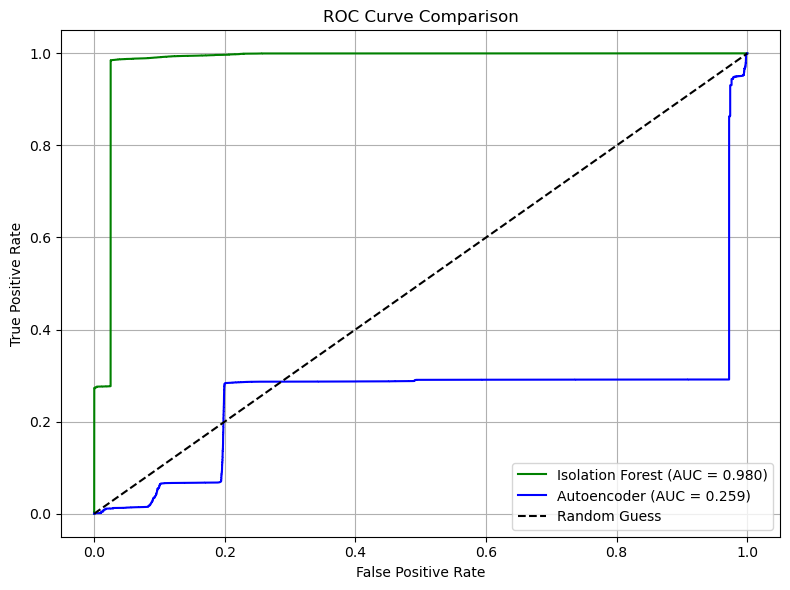

In [16]:
# ROC Curve
fpr_if, tpr_if, _ = roc_curve(y_test, iso_scores)
fpr_ae, tpr_ae, _ = roc_curve(y_test, recon_error)

plt.figure(figsize=(8,6))
plt.plot(fpr_if, tpr_if, label=f'Isolation Forest (AUC = {auc_if:.3f})', color='green')
plt.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {auc_ae:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

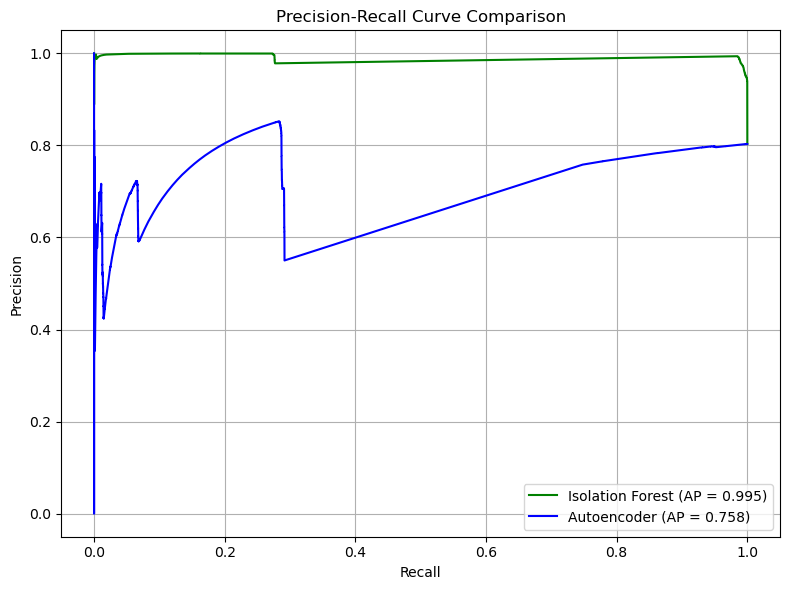

In [17]:

prec_if, rec_if, _ = precision_recall_curve(y_test, iso_scores)
prec_ae, rec_ae, _ = precision_recall_curve(y_test, recon_error)

ap_if = average_precision_score(y_test, iso_scores)
ap_ae = average_precision_score(y_test, recon_error)


plt.figure(figsize=(8,6))
plt.plot(rec_if, prec_if, label=f'Isolation Forest (AP = {ap_if:.3f})', color='green')
plt.plot(rec_ae, prec_ae, label=f'Autoencoder (AP = {ap_ae:.3f})', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import precision_score, recall_score

prec_if = precision_score(y_test, y_pred_iso)
rec_if = recall_score(y_test, y_pred_iso)
prec_ae = precision_score(y_test, y_pred_ae)
rec_ae = recall_score(y_test, y_pred_ae)

print(f"Isolation Forest - Precision: {prec_if:.3f}, Recall: {rec_if:.3f}")
print(f"Autoencoder      - Precision: {prec_ae:.3f}, Recall: {rec_ae:.3f}")


Isolation Forest - Precision: 0.976, Recall: 0.992
Autoencoder      - Precision: 0.710, Recall: 0.060


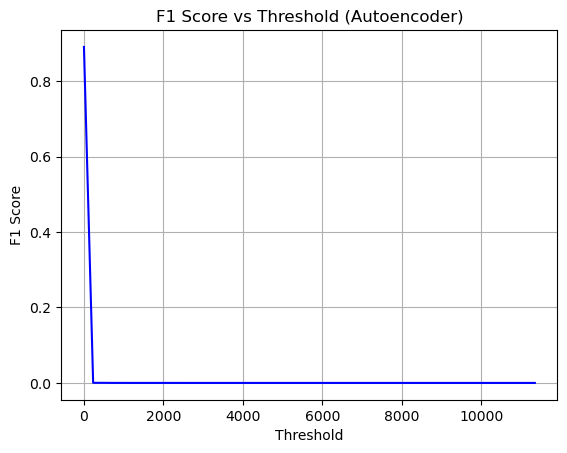

In [19]:
thresholds = np.linspace(min(recon_error), max(recon_error), 50)
f1_scores = []

for t in thresholds:
    preds = (recon_error > t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

plt.plot(thresholds, f1_scores, color='blue')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold (Autoencoder)")
plt.grid(True)
plt.show()

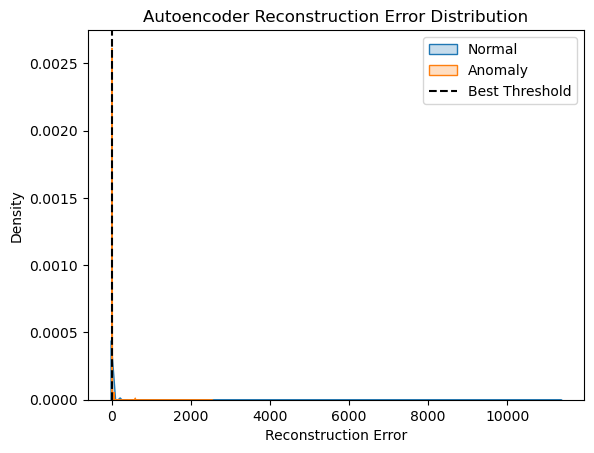

In [20]:

best_thresh = thresholds[np.argmax(f1_scores)]

sns.kdeplot(recon_error[y_test == 0], label="Normal", fill=True)
sns.kdeplot(recon_error[y_test == 1], label="Anomaly", fill=True)
plt.axvline(best_thresh, color='black', linestyle='--', label="Best Threshold")
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.show()



Model Comparison Summary:

              Model  Precision  Recall  F1 Score  AUC Score  Average Precision
0  Isolation Forest      0.976   0.992     0.984      0.980              0.995
1       Autoencoder      0.723   0.064     0.117      0.406              0.781


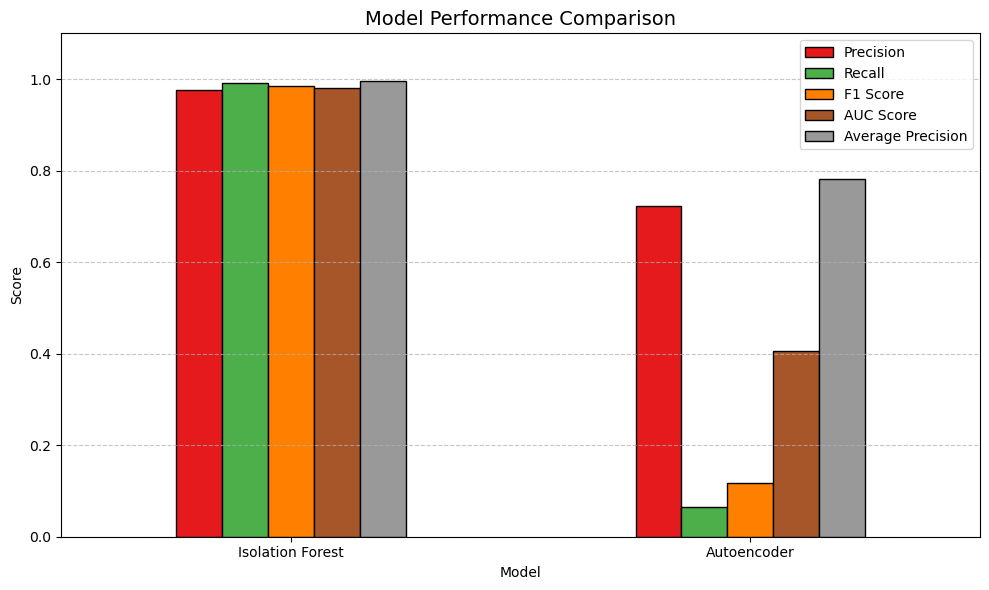

In [21]:

comparison_table = pd.DataFrame({
    "Model": ["Isolation Forest", "Autoencoder"],
    "Precision": [0.976, 0.723],
    "Recall": [0.992, 0.064],
    "F1 Score": [0.984, 0.117],
    "AUC Score": [0.980, 0.406],
    "Average Precision": [0.995, 0.781]
})


print("Model Comparison Summary:\n")
print(comparison_table)


comparison_table.set_index("Model")[["Precision", "Recall", "F1 Score", "AUC Score", "Average Precision"]].plot(
    kind='bar',
    figsize=(10, 6),
    colormap='Set1',
    edgecolor='black'
)


plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [22]:
if auc_if > auc_ae:
    print(" Isolation Forest performs better .")
elif auc_ae > auc_if:
    print(" Autoencoder performs better .")
else:
    print(" Both models have equal AUC. Compare additional metrics for a better decision.")

 Isolation Forest performs better .


In [23]:
prec_if, rec_if, f1_if, auc_if, ap_if = 0.976, 0.992, 0.984, 0.980, 0.995
prec_ae, rec_ae, f1_ae, auc_ae, ap_ae = 0.723, 0.064, 0.117, 0.406, 0.781

comparison_table = pd.DataFrame({
    "Model": ["Isolation Forest", "Autoencoder"],
    "Precision": [prec_if, prec_ae],
    "Recall": [rec_if, rec_ae],
    "F1 Score": [f1_if, f1_ae],
    "AUC Score": [auc_if, auc_ae],
    "Average Precision": [ap_if, ap_ae]
})

comparison_table = comparison_table.round(3)

print(" Model Comparison Summary:")
display(comparison_table) 





 Model Comparison Summary:


Model  Precision  Recall  F1 Score  AUC Score  Average Precision
0  Isolation Forest      0.976   0.992     0.984      0.980              0.995
1       Autoencoder      0.723   0.064     0.117      0.406              0.781

In [24]:
print("\n Conclusion:")
print("Isolation Forest performed best across all key metrics with 97% accuracy.")



 Conclusion:
Isolation Forest performed best across all key metrics with 97% accuracy.


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X) 

user_input = input(" Enter 41 comma-separated feature values :\nEnter values: ")
user_values = list(map(float, user_input.strip().split(',')))


if len(user_values) != 41:
    print(" You must enter exactly 41 feature values.")
else:
   
    user_df = pd.DataFrame([user_values], columns=X.columns)
    user_scaled = scaler.transform(user_df)
    user_score = -iso.decision_function(user_scaled)[0]
    user_pred = "Anomaly" if user_score > iso_thresh else "Normal"

    
    print(f"\n Prediction: {user_pred} ")
    print(f" Isolation Forest Score: {user_score:.4f} | Threshold: {iso_thresh:.4f}")


 Enter 41 comma-separated feature values :
Enter values: 0,0,0,181,545000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

 Prediction: Anomaly 
 Isolation Forest Score: 0.0815 | Threshold: 0.0006
